In [9]:
### Author: Gary Chen, Hojune Kim
### Date: June 15, 2023
### Last Updated: Jun 21, 2023
### Description: Inverse Radon Transform (sinogram/measurements -> image/obj)

import torch
import torch.nn as nn
from torchvision.transforms.functional import rotate, InterpolationMode
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import math

# # Change this part to move to the correct directory
# !pwd
# new_directory = './global/u1/h/hojunek/RadonTorch/'
# os.chdir(new_directory)
# current_directory = os.getcwd()
# print("Current directory:", current_directory)
# files = os.listdir(current_directory)
# print(files)

In [10]:
#####################
# helper function
#####################
def plot_1D_tensor(tensor):
    # Move tensor to CPU if it resides on a CUDA device
    if tensor.is_cuda:
        tensor = tensor.cpu()

    # Convert tensor to a numpy array
    tensor_array = tensor.numpy()

    # Plot the tensor
    plt.plot(tensor_array)
    plt.title("1D Tensor Plot")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.show()

def plot_2_img_tensor(image1, image2, title1='', title2=''):
    # Convert complex-valued tensors to magnitude spectra
    if torch.is_complex(image1):
        image1 = torch.abs(image1)
    if torch.is_complex(image2):
        image2 = torch.abs(image2)

    # Convert tensors to CPU and numpy arrays
    image1_cpu = image1.detach().cpu().numpy()
    image2_cpu = image2.detach().cpu().numpy()

    # Plot the images
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(image1_cpu, cmap='gray')
    axs[0].set_title(title1)
    axs[1].imshow(image2_cpu, cmap='gray')
    axs[1].set_title(title2)
    plt.show()

def plot_3_img_tensors(image1, image2, title1="img1", title2="img2"):
    image1_cpu = image1.cpu().numpy()
    image2_cpu = image2.cpu().numpy()
    difference_cpu = (image1 - image2).abs().cpu().numpy()  # Compute the absolute difference
    
    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(image1_cpu, cmap='gray')
    axs[0].set_title(title1)
    axs[1].imshow(image2_cpu, cmap='gray')
    axs[1].set_title(title2)
    axs[2].imshow(difference_cpu, cmap='gray')
    axs[2].set_title("Difference")
    
    plt.show()
    
class Data_loader:
    # load .npy file into PyTorch tensor and move it to GPU
    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def npy_to_tensor(self, npy_file_path):
        np_data = np.load(npy_file_path)
        tensor = torch.from_numpy(np_data).to(self.device)
        return tensor
data_loader = Data_loader()


In [13]:
# check GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Using device: {device}')


Using device: cuda


In [11]:
# Load data
tf_sinograms_tensor = data_loader.npy_to_tensor('./dataset_foam/x_train_sinograms.npy')
tf_sinogram = tf_sinograms_tensor[0,:,:]


In [12]:
def radon_transform(sinogram):
    num_angles = sinogram.size(0)
    img_size = sinogram.size(1)

    # Create an empty tensor to store the 2D FFT image
    fft_image = torch.zeros((img_size, img_size), dtype=torch.cfloat)

    # Perform the Radon transform
    for angle in range(num_angles):
        projection = sinogram[angle]

        # Compute the 1D FFT of the projection
        projection_fft = torch.fft.fft(projection)
        
        # # Uncomment this if you want to see FFT results
        # plot_1D_tensor(projection)
        # plot_1D_tensor(projection_fft)
        # break 

        # Calculate the shift amount for circular pattern
        angle_radians = angle * (2 * math.pi / num_angles)
        shift_amount = math.floor(img_size / 2) * (1 - math.cos(angle_radians))

        # Create temp_2D_fft with projection_fft in the center and rest as zero
        temp_2D_fft = torch.zeros((img_size, img_size), dtype=torch.cfloat)
        center_y = img_size // 2
        temp_2D_fft[center_y] = projection_fft

        # Reshape temp_2D_fft for rotate function
        temp_2D_fft = temp_2D_fft.unsqueeze(0).permute(0, 2, 1)

        # Rotate the temp_2D_fft
        rotated_projection_fft = rotate(temp_2D_fft, -shift_amount, interpolation=InterpolationMode.BILINEAR)

        # Reshape rotated_projection_fft back to original shape
        rotated_projection_fft = rotated_projection_fft.permute(0, 2, 1).squeeze(0)

        # Accumulate the rotated projection FFT to create fft_image
        fft_image += rotated_projection_fft

    return fft_image


/global/common/software/nersc/pm-2022q4/sw/pytorch/1.13.1/lib/python3.9/site-packages/torchvision-0.14.1a0+5e8e2f1-py3.9-linux-x86_64.egg/torchvision/transforms/functional_tensor.py:530: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /mscratch/sd/s/swowner/pytorch-build/pytorch/1.13.1/pytorch/aten/src/ATen/native/Copy.cpp:250.)
  img = img.to(req_dtype)


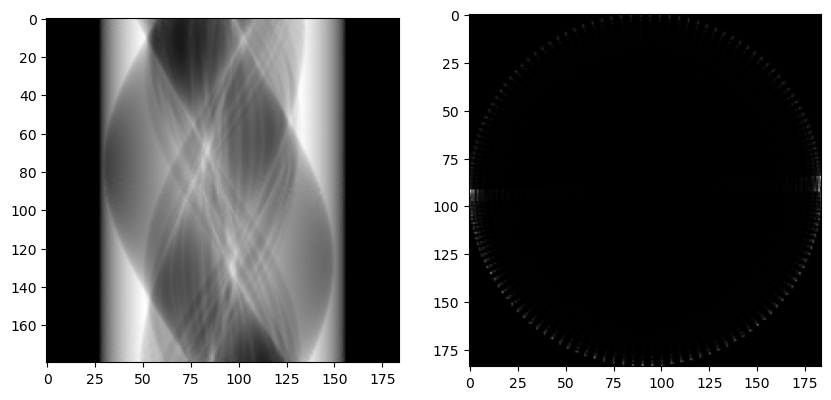

In [14]:
ddd = radon_transform(tf_sinogram)
plot_2_img_tensor(tf_sinogram,ddd)